#### Import libraries

In [ ]:
! pip install wandb

     |████████████████████████████████| 2.0MB 5.9MB/s 
     |████████████████████████████████| 133kB 19.7MB/s 
     |████████████████████████████████| 163kB 18.8MB/s 
     |████████████████████████████████| 102kB 8.0MB/s 
     |████████████████████████████████| 71kB 7.0MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=02bb973b1432d7c68cbe1c0c351f960941bcf6e06bad4e830180c651546c3e07
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=0f12e9cdbdea22d40a37c96420966d042d8adf0083f01cc106a96a914eae5ef8
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist, fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")
import wandb

#### Download data

In [ ]:
(X, y), (X_test, y_test) = fashion_mnist.load_data()

# Reshaping the data matrices
X = X.reshape(X.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# Normalizing the pixel intensities
X = X/255.0
X_test = X_test/255.0

# Split the X_train into a training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
# Number of training examples
M = X_train.shape[0]

# Number of validation samples
Mval = X_val.shape[0]

# Number of test examples
Mtest = X_test.shape[0]

# Number of features in the dataset
num_features = 784

# Number of classes
num_classes = len(np.unique(y_train))

# One hot encoding for class labels
y_train_one_hot = np.zeros((10, M))
y_train_one_hot[y_train, np.array(list(range(M)))] = 1
# y_train_one_hot = y_train_one_hot.T

y_val_one_hot = np.zeros((10, Mval))
y_val_one_hot[y_val, np.array(list(range(Mval)))] = 1
# y_val_one_hot = y_val_one_hot.T

y_test_one_hot = np.zeros((10, Mtest))
y_test_one_hot[y_test, np.array(list(range(Mtest)))] = 1
# y_test_one_hot = y_test_one_hot.T

print("Number of images in the training set =", M)
print("Number of images in the validation set =", Mval)
print("Number of images in the test set =", Mtest)
print("Number of classes =", num_classes)
print("Number of features per example =", num_features)

Number of images in the training set = 54000
Number of images in the validation set = 6000
Number of images in the test set = 10000
Number of classes = 10
Number of features per example = 784


In [ ]:
# Modify shapes of the data matrices
X_train = X_train.T
X_val = X_val.T
X_test = X_test.T

#### Number of neurons in the input and output layers

In [ ]:
input_nodes = num_features
output_nodes = num_classes

#### Activation functions and their derivatives

In [ ]:
def sigmoid(x):
    return 1. / (1.+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1-sigmoid(x))

def Relu(x):
    return np.maximum(0,x)

def Relu_derivative(x):
    return 1*(x>0) 

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return (1 - (np.tanh(x)**2))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(x):
    return softmax(x) * (1-softmax(x))

#cross-entropy for our cost function
def compute_multiclass_loss(Y, Y_hat, batch_size, loss, lamb, parameters):

    if loss == 'categorical_crossentropy':
         L = (-1.0 * np.sum(np.multiply(Y, np.log(Y_hat))))/batch_size
    elif loss == 'mse':
         L = (1/2) * np.sum((Y-Y_hat)**2)/batch_size

    acc = 0
    for i in range(1, len(parameters)//2 + 1):
        acc += np.sum(parameters["W"+str(i)]**2)

    L = L + (lamb/(2*batch_size))*acc

    return L

#### Initialize parameters

In [ ]:
def initialize_parameters(layer_dims, init_mode="xavier"):
    np.random.seed(42)
    params = {}
    previous_updates = {}
    for i in range(1, len(layer_dims)):
        if init_mode == 'random_normal':
            params["W"+str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'random_uniform':
            params["W"+str(i)] = np.random.rand(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'xavier':
            params["W"+str(i)]= np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/(layer_dims[i]+layer_dims[i-1]))
            
        params["b"+str(i)] = np.zeros((layer_dims[i], 1))
        
        previous_updates["W"+str(i)] = np.zeros((layer_dims[i], layer_dims[i-1]))
        previous_updates["b"+str(i)] = np.zeros((layer_dims[i], 1))

    return params,previous_updates

#### Forward Propagation

In [ ]:
def forward_propagate(X, params, activation_f):
    L = len(params)//2 + 1
    A = [None]*L # activations
    Z = [None]*L # pre-activations
    
    A[0] = X
    
    for l in range(1, L):
        W = params["W"+str(l)]
        b = params["b"+str(l)]
        
        Z[l] = np.matmul(W,A[l-1]) + b
        
        if l == L-1:
            A[l] = softmax(Z[l]) # activation function for output layer
        else:
            if activation_f == 'sigmoid':
                A[l] = sigmoid(Z[l])
            elif activation_f == 'relu':
                A[l] = Relu(Z[l])
            elif activation_f == 'tanh':
                A[l] = tanh(Z[l])
                
    output = A[L-1]

    return output,A,Z

#### Backpropagation

In [ ]:
def backprop(y_hat, y,A, Z, params, activation_f, batch_size, loss, lamb):
    L = len(params)//2
    gradients = {}
    
    if loss == 'categorical_crossentropy':
        gradients["dZ"+str(L)] = A[L]-y
    elif loss == 'mse':
        gradients["dZ"+str(L)] = (A[L]-y) * softmax_derivative(Z[L])
    
    for l in range(L,0,-1):
        gradients["dW" + str(l)] = (np.dot(gradients["dZ" + str(l)], A[l-1].T) + lamb*params["W"+str(l)]) / batch_size
        gradients["db" + str(l)] = np.sum(gradients["dZ" + str(l)], axis=1, keepdims=True) / batch_size
        
        if l>1:
            if activation_f == 'sigmoid':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * sigmoid_derivative(Z[l-1])
            elif activation_f == 'relu':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * Relu_derivative(Z[l-1])
            elif activation_f == 'tanh':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * tanh_derivative(Z[l-1])
        
    return gradients

#### Optimizers

This block contains functions that implement stochastic gradient descent, momentum, RMSprop, Adam. Nadam and Nestorov accelerated gradient are implemented inside the NN_fit function.

In [ ]:
def update_params_sgd(parameters,grads,learning_rate):
    L = len(parameters) // 2 
    
    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

def update_parameters_momentum(parameters, grads, learning_rate, beta, previous_updates):
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(1, L + 1):
        previous_updates["W"+str(l)] = beta*previous_updates["W"+str(l)] + (1-beta)*grads["dW" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*previous_updates["W"+str(l)]
        
        previous_updates["b"+str(l)] = beta*previous_updates["b"+str(l)] + (1-beta)*grads["db" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*previous_updates["b"+str(l)]

    return parameters, previous_updates
    
def update_parameters_RMSprop(parameters, grads, learning_rate, beta, v):

    L = len(parameters) // 2 # number of layers in the neural network
    delta = 1e-6 # for numerical stability

    for l in range(1, L + 1):
        vdw = beta*v["W" + str(l)] + (1-beta)*np.multiply(grads["dW" + str(l)],grads["dW" + str(l)])
        vdb = beta*v["b" + str(l)] + (1-beta)*np.multiply(grads["db" + str(l)],grads["db" + str(l)])

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)] / (np.sqrt(vdw)+delta)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)] / (np.sqrt(vdb)+delta)

        v["W" + str(l)] = vdw
        v["b" + str(l)] = vdb

    return parameters,v

def update_parameters_adam(parameters, grads, learning_rate, v, m, t):
    L = len(parameters) // 2 # number of layers in the neural network
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    for l in range(1, L+1):
        mdw = beta1*m["W"+str(l)] + (1-beta1)*grads["dW"+str(l)]
        vdw = beta2*v["W"+str(l)] + (1-beta2)*np.square(grads["dW"+str(l)])
        mw_hat = mdw/(1.0 - beta1**t)
        vw_hat = vdw/(1.0 - beta2**t)

        parameters["W"+str(l)] = parameters["W"+str(l)] - (learning_rate * mw_hat)/np.sqrt(vw_hat + epsilon)

        mdb = beta1*m["b"+str(l)] + (1-beta1)*grads["db"+str(l)]
        vdb = beta2*v["b"+str(l)] + (1-beta2)*np.square(grads["db"+str(l)])
        mb_hat = mdb/(1.0 - beta1**t)
        vb_hat = vdb/(1.0 - beta2**t)

        parameters["b"+str(l)] = parameters["b"+str(l)] - (learning_rate * mb_hat)/np.sqrt(vb_hat + epsilon)

        v["dW"+str(l)] = vdw
        m["dW"+str(l)] = mdw
        v["db"+str(l)] = vdb
        m["db"+str(l)] = mdb

    t = t + 1 # timestep
    return parameters, v, m, t

In [ ]:
def plot_cost_curve(train_costs, val_costs):
    plt.plot(list(range(len(train_costs))), train_costs, 'r', label="Training loss")
    plt.plot(list(range(len(val_costs))), val_costs, 'lime', label="Validation loss")
    plt.title("Training and Validation Loss vs Number of Epochs", size=16)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()

#### Function to fit the model

In [66]:
#def NN_fit(X,y,X_val,y_val, learning_rate=0.01, activation_f='sigmoid', init_mode='xavier', optimizer = 'sgd', batch_size=512, loss = 'categorical_crossentropy', epochs=10, L2_lamb=0, num_neurons=64, num_hidden=3):
def NN_fit():
    # Default values for hyper-parameters
    config_defaults = {
        'epochs': 10,
        'batch_size': 64,
        'learning_rate': 1e-3,
        'activation_f': 'relu',
        'optimizer': 'adam',
        'init_mode': 'xavier',
        'L2_lamb': 0,
        'num_neurons': 64,
        'num_hidden': 3
    }


    # Initialize a new wandb run
    #wandb.init(name="lr{}_ac_{}_in_{}_op_{}_bs_{}_L2_{}_ep_{}_nn_{}_nh_{}".format(learning_rate, activation_f, init_mode, optimizer, batch_size, L2_lamb, epochs, num_neurons, num_hidden), config=config_defaults)
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Local variables, values obtained from wandb config
    num_neurons = config.num_neurons
    num_hidden = config.num_hidden
    init_mode = config.init_mode
    epochs = config.epochs
    batch_size = config.batch_size
    learning_rate = config.learning_rate
    activation_f = config.activation_f
    L2_lamb = config.L2_lamb
    optimizer = config.optimizer

    # Display the hyperparameters
    run_name = "lr_{}_ac_{}_in_{}_op_{}_bs_{}_L2_{}_ep_{}_nn_{}_nh_{}".format(learning_rate, activation_f, init_mode, optimizer, batch_size, L2_lamb, epochs, num_neurons, num_hidden)
    print(run_name)

    #Layer sizes
    layer_dims = [num_features] + [num_neurons]*num_hidden + [num_classes]

    params, previous_updates = initialize_parameters(layer_dims, init_mode)
    
    epoch_cost = []
    validation_epoch_cost = []
    
    count = 1
    t = 1 # initialize timestep for Adam optimizer
    v = previous_updates.copy()
    m = previous_updates.copy()
    params_look_ahead = params.copy() # initialization for nestorov
    beta = 0.9
    loss = 'categorical_crossentropy'    

    while count<=epochs:
        count = count + 1 # increment the number of epochs
        for i in range(0, X_train.shape[1], batch_size):
            batch_count = batch_size
            if i + batch_size > X_train.shape[1]: # the last mini-batch might contain fewer than "batch_size" examples
                batch_count = X_train.shape[1] - i + 1

            if optimizer == 'nesterov':
                L = len(params)//2
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]
                    
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                
            elif optimizer=='nadam':
                L = len(params)//2
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]

                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

            else:
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params,activation_f, batch_count, loss, L2_lamb)

                if optimizer == 'sgd':
                    params = update_params_sgd(params,gradients,learning_rate)
                elif optimizer == 'momentum':
                    params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'RMSprop':
                    params,previous_updates = update_parameters_RMSprop(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'adam':
                    params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

        # Mean loss for the full training set
        full_output, _, _ = forward_propagate(X_train, params, activation_f)
        cost = compute_multiclass_loss(y_train_one_hot, full_output, M, loss, L2_lamb, params)
        epoch_cost.append(cost)
        
        # Mean loss for the validation set
        out, _, _ = forward_propagate(X_val, params, activation_f)
        val_cost = compute_multiclass_loss(y_val_one_hot, out, Mval,loss, L2_lamb, params)
        validation_epoch_cost.append(val_cost)

        # Training accuracy at the end of the epoch
        train_predictions = NN_predict(X_train, params, activation_f)
        train_acc = accuracy_score(y_train, train_predictions)

        # Validation accuracy at the end of the epoch
        val_predictions = NN_predict(X_val, params, activation_f)
        val_acc = accuracy_score(y_val, val_predictions)

        wandb.log({"training_acc": train_acc, "validation_accuracy": val_acc, "training_loss": cost, "validation cost": val_cost, 'epoch': count})

        if (count % 2 == 0):
            print("Epoch number : {}".format(count))
            print("Training cost: ", cost, "\tValidation cost:",val_cost)


    print("\nFinal training cost:", cost)
    
    # Plot the training and validation cost curves
    plot_cost_curve(epoch_cost, validation_epoch_cost)

    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()
    
    return params, epoch_cost

In [67]:
def NN_predict(X_test, params, activation_f):
    output, _, _ = forward_propagate(X_test, params, activation_f)
    predictions = np.argmax(output, axis=0)
    return predictions

def NN_evaluate(X_train, y_train, X_test, y_test, params, activation_f):
    train_predictions = NN_predict(X_train, params, activation_f)
    test_predictions = NN_predict(X_test, params, activation_f)

    print("Training accuracy = {} %".format(round(accuracy_score(y_train, train_predictions) * 100), 3))
    print("Test accuracy = {} %".format(round(accuracy_score(y_test, test_predictions) * 100), 3))

    print("Classification report for the test set:\n")
    print(classification_report(y_test, test_predictions))

#### Setting Hyperparameters

In [54]:
layer_dims= [input_nodes,64,64,output_nodes]
LEARNING_RATE = 0.01
ACTIVATION = "tanh"
INITIALIZER = "xavier"
OPTIMIZER = "RMSprop"
BATCH_SIZE = 128
LOSS = 'categorical_crossentropy'
EPOCHS = 50
# BETA = 0.9
L2_lambda = 0

#### W&B part

Create sweep with ID: iggpt3b2
Sweep URL: https://wandb.ai/ee17b154tony/dl_assignment1/sweeps/iggpt3b2


wandb: Agent Starting Run: ng7ik82c with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum


lr_0.0001_ac_relu_in_random_uniform_op_momentum_bs_32_L2_0.0005_ep_5_nn_32_nh_4
Epoch number : 2
Training cost:  2.3025774663239593 	Validation cost: 2.3025793072287515
Epoch number : 4
Training cost:  2.302575191402498 	Validation cost: 2.302582088398975
Epoch number : 6
Training cost:  2.3025729458516215 	Validation cost: 2.302584729696136

Final training cost: 2.3025729458516215


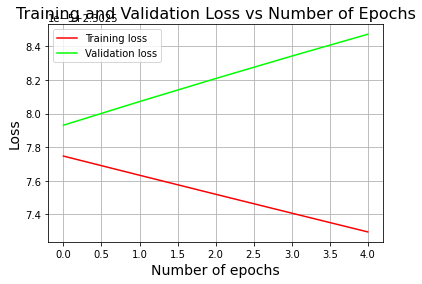

training_acc,0.10093
validation_accuracy,0.09167
training_loss,2.30257
validation cost,2.30258
epoch,6
_runtime,20
_timestamp,1615358483
_step,4


training_acc,▇█▂▁▁
validation_accuracy,██▂▁▁
training_loss,█▆▄▃▁
validation cost,▁▃▅▆█
epoch,▁▃▅▆█
_runtime,▁▃▅▇█
_timestamp,▁▃▅▇█
_step,▁▃▅▆█


wandb: Agent Starting Run: 6cxfhzpt with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.001_ac_tanh_in_random_uniform_op_sgd_bs_512_L2_0.5_ep_20_nn_128_nh_3
Epoch number : 2
Training cost:  2.3009976746767165 	Validation cost: 2.3010894529268917
Epoch number : 4
Training cost:  2.297925987980202 	Validation cost: 2.2977320802118726
Epoch number : 6
Training cost:  2.2957907550906653 	Validation cost: 2.2953684557144465
Epoch number : 8
Training cost:  2.2942416557923577 	Validation cost: 2.2936360270814546
Epoch number : 10
Training cost:  2.293063671770739 	Validation cost: 2.292310465567528
Epoch number : 12
Training cost:  2.2921211232631546 	Validation cost: 2.29124873501497
Epoch number : 14
Training cost:  2.2913270876865472 	Validation cost: 2.2903580014889227
Epoch number : 16
Training cost:  2.290625417983523 	Validation cost: 2.2895773461823494
Epoch number : 18
Training cost:  2.289979662536442 	Validation cost: 2.2888664734511712
Epoch number : 20
Training cost:  2.2893660526235373 	Validation cost: 2.288198533616424

Final training cost: 2.28906619974964

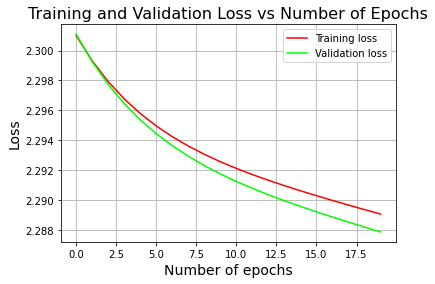

training_acc,0.0995
validation_accuracy,0.1045
training_loss,2.28907
validation cost,2.28787
epoch,21
_runtime,162
_timestamp,1615358652
_step,19


training_acc,██████▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁██████████████
training_loss,█▇▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
validation cost,█▇▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: as8sh22w with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.0001_ac_tanh_in_xavier_op_nadam_bs_16_L2_0.0005_ep_20_nn_128_nh_5
Epoch number : 2
Training cost:  0.4579883117841987 	Validation cost: 0.4665988318341053
Epoch number : 4
Training cost:  0.38125919551652276 	Validation cost: 0.40192437004667336
Epoch number : 6
Training cost:  0.35483502994743754 	Validation cost: 0.3921215420453955
Epoch number : 8
Training cost:  0.33423209304611673 	Validation cost: 0.3852144920218103
Epoch number : 10
Training cost:  0.3273818998323047 	Validation cost: 0.3875972635837415
Epoch number : 12
Training cost:  0.3096505464849466 	Validation cost: 0.3822437929237359
Epoch number : 14
Training cost:  0.3120615719443426 	Validation cost: 0.3943819820004828
Epoch number : 16
Training cost:  0.3245878175564637 	Validation cost: 0.4231079484343887
Epoch number : 18
Training cost:  0.29821194996963296 	Validation cost: 0.40407870321300704
Epoch number : 20
Training cost:  0.2990856929176804 	Validation cost: 0.4143816156382031

Final training cost: 0.305

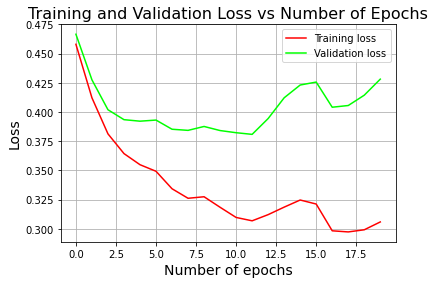

training_acc,0.90494
validation_accuracy,0.87717
training_loss,0.3058
validation cost,0.42814
epoch,21
_runtime,911
_timestamp,1615359569
_step,19


training_acc,▁▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇████
validation_accuracy,▁▄▅▆▆▇▇██████▇▇▇███▇
training_loss,█▆▅▄▄▃▃▂▂▂▂▁▂▂▂▂▁▁▁▁
validation cost,█▅▃▂▂▂▁▁▂▁▁▁▂▄▄▅▃▃▄▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2n4ue1q7 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nestorov


lr_0.001_ac_sigmoid_in_random_uniform_op_nestorov_bs_16_L2_0_ep_20_nn_64_nh_4
Epoch number : 2
Training cost:  2.3026448356458267 	Validation cost: 2.302660787495611
Epoch number : 4
Training cost:  2.3026448356458267 	Validation cost: 2.302660787495611
Epoch number : 6
Training cost:  2.3026448356458267 	Validation cost: 2.302660787495611
Epoch number : 8
Training cost:  2.3026448356458267 	Validation cost: 2.302660787495611
Epoch number : 10
Training cost:  2.3026448356458267 	Validation cost: 2.302660787495611
Epoch number : 12
Training cost:  2.3026448356458267 	Validation cost: 2.302660787495611
Epoch number : 14
Training cost:  2.3026448356458267 	Validation cost: 2.302660787495611
Epoch number : 16
Training cost:  2.3026448356458267 	Validation cost: 2.302660787495611
Epoch number : 18
Training cost:  2.3026448356458267 	Validation cost: 2.302660787495611
Epoch number : 20
Training cost:  2.3026448356458267 	Validation cost: 2.302660787495611

Final training cost: 2.302644835645

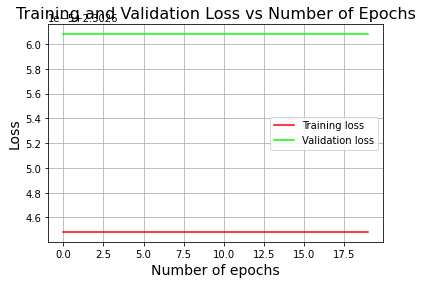

training_acc,0.09985
validation_accuracy,0.10133
training_loss,2.30264
validation cost,2.30266
epoch,21
_runtime,203
_timestamp,1615359798
_step,19


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: xdcxtmb9 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.0001_ac_tanh_in_xavier_op_adam_bs_16_L2_0.5_ep_20_nn_64_nh_5
Epoch number : 2
Training cost:  0.681522118210492 	Validation cost: 0.6907393948869545
Epoch number : 4
Training cost:  0.6674744047790859 	Validation cost: 0.6760961965257348
Epoch number : 6
Training cost:  0.6661095786401979 	Validation cost: 0.6744343573391107
Epoch number : 8
Training cost:  0.6653424127797831 	Validation cost: 0.673667795227364
Epoch number : 10
Training cost:  0.664061221972646 	Validation cost: 0.6724260182068417
Epoch number : 12
Training cost:  0.6630527655459678 	Validation cost: 0.6714849341822984
Epoch number : 14
Training cost:  0.6628528983757725 	Validation cost: 0.6713441302430991
Epoch number : 16
Training cost:  0.6624613193119928 	Validation cost: 0.6708768414381602
Epoch number : 18
Training cost:  0.6620046701709528 	Validation cost: 0.6703497315126781
Epoch number : 20
Training cost:  0.6618233695394754 	Validation cost: 0.6701513622866425

Final training cost: 0.6618030277119664


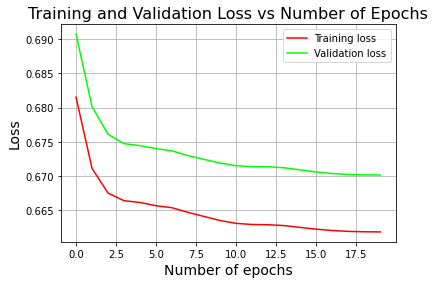

training_acc,0.78954
validation_accuracy,0.7905
training_loss,0.6618
validation cost,0.67013
epoch,21
_runtime,432
_timestamp,1615360237
_step,19


training_acc,▁▂▂▃▅▆▆▆▇▇██▇▆▇▆▇▇▇▆
validation_accuracy,▁▂▂▄▅▇▆██▇▇▇▇▇▇▇▇█▇▇
training_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
validation cost,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 7d6gu5tj with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.0001_ac_relu_in_random_uniform_op_adam_bs_16_L2_0.0005_ep_5_nn_128_nh_4
Epoch number : 2
Training cost:  1.661706017685883 	Validation cost: 1.6554379263721293
Epoch number : 4
Training cost:  0.9043210753142699 	Validation cost: 0.9005367012937996
Epoch number : 6
Training cost:  0.6099235620138789 	Validation cost: 0.6408672092199436

Final training cost: 0.6099235620138789


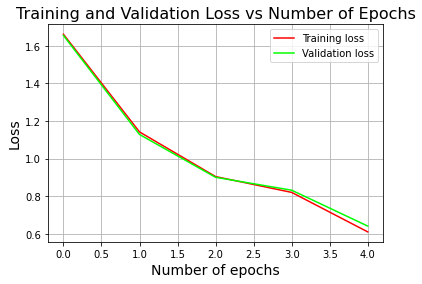

training_acc,0.81002
validation_accuracy,0.803
training_loss,0.60992
validation cost,0.64087
epoch,6
_runtime,165
_timestamp,1615360409
_step,4


training_acc,▁▄▆▇█
validation_accuracy,▁▄▆▇█
training_loss,█▅▃▂▁
validation cost,█▄▃▂▁
epoch,▁▃▅▆█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: idcd6hms with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


lr_0.001_ac_relu_in_random_uniform_op_nestorov_bs_64_L2_0.5_ep_5_nn_128_nh_5
Epoch number : 2
Training cost:  2.301905326809285 	Validation cost: 2.3019970627362047
Epoch number : 4
Training cost:  2.301905326809285 	Validation cost: 2.3019970627362047
Epoch number : 6
Training cost:  2.301905326809285 	Validation cost: 2.3019970627362047

Final training cost: 2.301905326809285


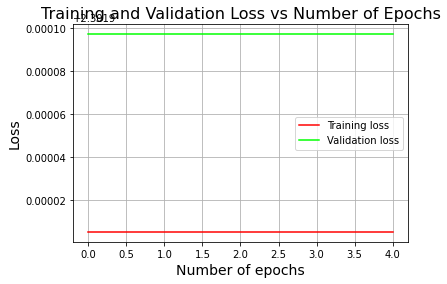

training_acc,0.09965
validation_accuracy,0.10317
training_loss,2.30191
validation cost,2.302
epoch,6
_runtime,46
_timestamp,1615360472
_step,4


training_acc,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
training_loss,▁▁▁▁▁
validation cost,▁▁▁▁▁
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 2ca00pbt with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.0001_ac_tanh_in_random_uniform_op_nadam_bs_64_L2_0.5_ep_20_nn_32_nh_4
Epoch number : 2
Training cost:  2.3025856751711298 	Validation cost: 2.3025922038485125
Epoch number : 4
Training cost:  2.302621093438052 	Validation cost: 2.3026560098558693
Epoch number : 6
Training cost:  2.3026756281889784 	Validation cost: 2.3027368295469635
Epoch number : 8
Training cost:  2.302721584199794 	Validation cost: 2.302797165339379
Epoch number : 10
Training cost:  2.302753388150704 	Validation cost: 2.3028355045305267
Epoch number : 12
Training cost:  2.3027732713310165 	Validation cost: 2.3028577926744833
Epoch number : 14
Training cost:  2.3027834534698446 	Validation cost: 2.302868478384318
Epoch number : 16
Training cost:  2.302782821448372 	Validation cost: 2.30286749567597
Epoch number : 18
Training cost:  2.302765232515156 	Validation cost: 2.302848715610313
Epoch number : 20
Training cost:  2.3027279730911827 	Validation cost: 2.302807978624698

Final training cost: 2.3027065030770504

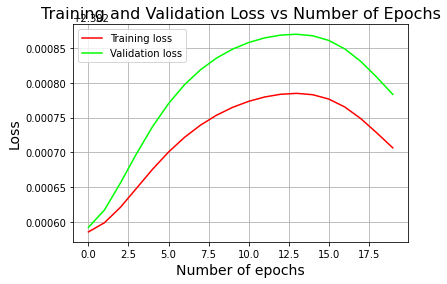

training_acc,0.09965
validation_accuracy,0.10317
training_loss,2.30271
validation cost,2.30278
epoch,21
_runtime,87
_timestamp,1615360566
_step,19


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▂▃▄▅▆▆▇▇██████▇▇▆▅
validation cost,▁▂▃▄▅▅▆▇▇▇██████▇▇▆▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: mn98y39g with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.0001_ac_tanh_in_xavier_op_momentum_bs_32_L2_0_ep_10_nn_64_nh_5
Epoch number : 2
Training cost:  2.056110238041797 	Validation cost: 2.061406544847211
Epoch number : 4
Training cost:  1.6424431581549062 	Validation cost: 1.6510628359674377
Epoch number : 6
Training cost:  1.3935384500085124 	Validation cost: 1.4026258828190241
Epoch number : 8
Training cost:  1.2324866248301378 	Validation cost: 1.2413670886935513
Epoch number : 10
Training cost:  1.12093434680649 	Validation cost: 1.129200324224724

Final training cost: 1.0773765544465155


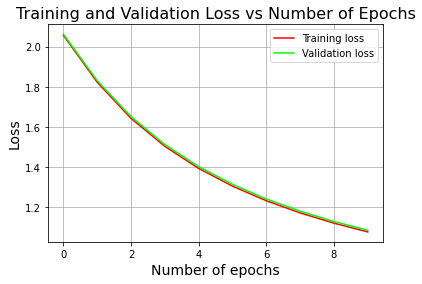

training_acc,0.67396
validation_accuracy,0.67467
training_loss,1.07738
validation cost,1.08526
epoch,11
_runtime,112
_timestamp,1615360685
_step,9


training_acc,▁▅▆▇▇▇▇███
validation_accuracy,▁▅▆▇▇▇▇███
training_loss,█▆▅▄▃▃▂▂▁▁
validation cost,█▆▅▄▃▃▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▇▇█
_timestamp,▁▂▃▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: gmijfgch with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.001_ac_relu_in_xavier_op_RMSprop_bs_64_L2_0_ep_5_nn_64_nh_5
Epoch number : 2
Training cost:  0.4374110808240913 	Validation cost: 0.45087536823245
Epoch number : 4
Training cost:  0.3227657742285 	Validation cost: 0.35757264012570295
Epoch number : 6
Training cost:  0.2945643805217156 	Validation cost: 0.34401731052960494

Final training cost: 0.2945643805217156


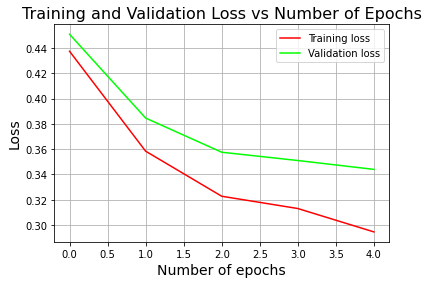

training_acc,0.89056
validation_accuracy,0.87733
training_loss,0.29456
validation cost,0.34402
epoch,6
_runtime,33
_timestamp,1615360726
_step,4


training_acc,▁▅▇▇█
validation_accuracy,▁▅▇▇█
training_loss,█▄▂▂▁
validation cost,█▄▂▁▁
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 042q78fc with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.001_ac_tanh_in_xavier_op_nestorov_bs_32_L2_0.0005_ep_10_nn_32_nh_5
Epoch number : 2
Training cost:  2.3316223701045184 	Validation cost: 2.3306101342105974
Epoch number : 4
Training cost:  2.3316223701045184 	Validation cost: 2.3306101342105974
Epoch number : 6
Training cost:  2.3316223701045184 	Validation cost: 2.3306101342105974
Epoch number : 8
Training cost:  2.3316223701045184 	Validation cost: 2.3306101342105974
Epoch number : 10
Training cost:  2.3316223701045184 	Validation cost: 2.3306101342105974

Final training cost: 2.3316223701045184


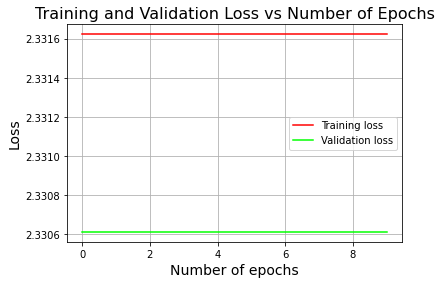

training_acc,0.12359
validation_accuracy,0.123
training_loss,2.33162
validation cost,2.33061
epoch,11
_runtime,52
_timestamp,1615360786
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: f1rhme1b with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd


lr_0.001_ac_tanh_in_random_uniform_op_sgd_bs_32_L2_0_ep_5_nn_32_nh_5
Epoch number : 2
Training cost:  2.302582579278542 	Validation cost: 2.3026059312502665
Epoch number : 4
Training cost:  2.302579839784331 	Validation cost: 2.3026396100913344
Epoch number : 6
Training cost:  2.302578386048281 	Validation cost: 2.3026641251281736

Final training cost: 2.302578386048281


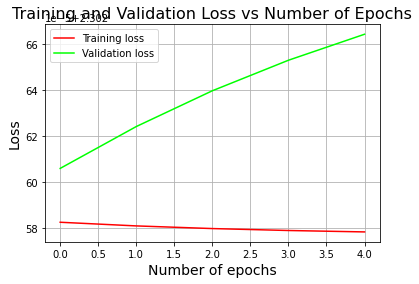

training_acc,0.10093
validation_accuracy,0.09167
training_loss,2.30258
validation cost,2.30266
epoch,6
_runtime,27
_timestamp,1615360821
_step,4


training_acc,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
training_loss,█▆▃▂▁
validation cost,▁▃▅▇█
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: kfb8sdls with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.001_ac_tanh_in_xavier_op_RMSprop_bs_16_L2_0.0005_ep_20_nn_64_nh_5
Epoch number : 2
Training cost:  0.4687779657172656 	Validation cost: 0.4888049233687649
Epoch number : 4
Training cost:  0.3798918976525289 	Validation cost: 0.4167563174416779
Epoch number : 6
Training cost:  0.35673743500517435 	Validation cost: 0.40857902161256904
Epoch number : 8
Training cost:  0.33820800963589837 	Validation cost: 0.395217235012631
Epoch number : 10
Training cost:  0.33477825916826315 	Validation cost: 0.40504292687288546
Epoch number : 12
Training cost:  0.3304159533647277 	Validation cost: 0.435526831056536
Epoch number : 14
Training cost:  0.28636598065716673 	Validation cost: 0.3839071256468131
Epoch number : 16
Training cost:  0.31555249347450876 	Validation cost: 0.4111894218874133
Epoch number : 18
Training cost:  0.31402292440606366 	Validation cost: 0.4252356988271154
Epoch number : 20
Training cost:  0.2829447863466376 	Validation cost: 0.4021612870332002

Final training cost: 0.277

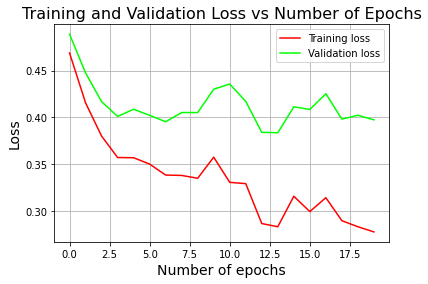

training_acc,0.90287
validation_accuracy,0.87033
training_loss,0.27741
validation cost,0.39729
epoch,21
_runtime,348
_timestamp,1615361178
_step,19


training_acc,▁▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_accuracy,▁▄▆▇▆▇▇▇█▆▆▇████▇█▇█
training_loss,█▆▅▄▄▄▃▃▃▄▃▃▁▁▂▂▂▁▁▁
validation cost,█▅▃▂▃▂▂▂▂▄▄▃▁▁▃▃▄▂▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: syn28jkl with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.001_ac_relu_in_random_uniform_op_sgd_bs_16_L2_0.0005_ep_10_nn_64_nh_5
Epoch number : 2
Training cost:  2.3023073712512434 	Validation cost: 2.302332642232655
Epoch number : 4
Training cost:  2.301621824987732 	Validation cost: 2.301666481561948
Epoch number : 6
Training cost:  2.3000328988322174 	Validation cost: 2.300031989522264
Epoch number : 8
Training cost:  2.292007607302907 	Validation cost: 2.2916021692883026
Epoch number : 10
Training cost:  2.2208701379543014 	Validation cost: 2.2164865736600086

Final training cost: 2.148194658450215


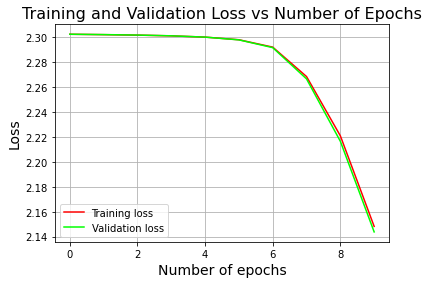

training_acc,0.17096
validation_accuracy,0.17517
training_loss,2.14819
validation cost,2.14378
epoch,11
_runtime,95
_timestamp,1615361282
_step,9


training_acc,▇▇██▇▇▂▁▃▇
validation_accuracy,▆▆▇▇▆▇▂▁▃█
training_loss,███████▆▄▁
validation cost,███████▆▄▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 5ho2tfij with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.001_ac_tanh_in_xavier_op_adam_bs_64_L2_0.0005_ep_20_nn_64_nh_4
Epoch number : 2
Training cost:  0.6052210995507161 	Validation cost: 0.6204664840955609
Epoch number : 4
Training cost:  0.3729381638178268 	Validation cost: 0.39928418592067805
Epoch number : 6
Training cost:  0.32990871646920794 	Validation cost: 0.37006847709905705
Epoch number : 8
Training cost:  0.3251365242694895 	Validation cost: 0.3809130873524339
Epoch number : 10
Training cost:  0.3078899253378541 	Validation cost: 0.3714791842288411
Epoch number : 12
Training cost:  0.31108651107395324 	Validation cost: 0.38971023103353797
Epoch number : 14
Training cost:  0.29526569334257013 	Validation cost: 0.38975720221422494
Epoch number : 16
Training cost:  0.2852346183115427 	Validation cost: 0.3829883549812324
Epoch number : 18
Training cost:  0.29016205403676326 	Validation cost: 0.3930413374240234
Epoch number : 20
Training cost:  0.2814786206999877 	Validation cost: 0.4047926800115195

Final training cost: 0.2810

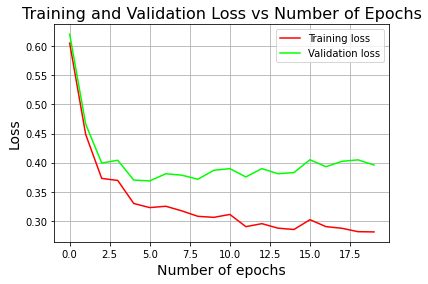

training_acc,0.89967
validation_accuracy,0.87217
training_loss,0.28108
validation cost,0.39592
epoch,21
_runtime,189
_timestamp,1615361480
_step,19


training_acc,▁▄▆▆▇▇▇▇▇▇▇█████████
validation_accuracy,▁▅▇▇▇▇▇█████████████
training_loss,█▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
validation cost,█▄▂▂▁▁▁▁▁▂▂▁▂▁▁▂▂▂▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 7apas6k9 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.001_ac_tanh_in_random_uniform_op_momentum_bs_64_L2_0.5_ep_10_nn_128_nh_3
Epoch number : 2
Training cost:  2.2936812175229746 	Validation cost: 2.292998294395417
Epoch number : 4
Training cost:  2.287637198431748 	Validation cost: 2.286357535046389
Epoch number : 6
Training cost:  2.2821806177425836 	Validation cost: 2.2806832945513826
Epoch number : 8
Training cost:  2.2753988942730303 	Validation cost: 2.2737176300838198
Epoch number : 10
Training cost:  2.266384775220632 	Validation cost: 2.264515617323468

Final training cost: 2.2605619037155176


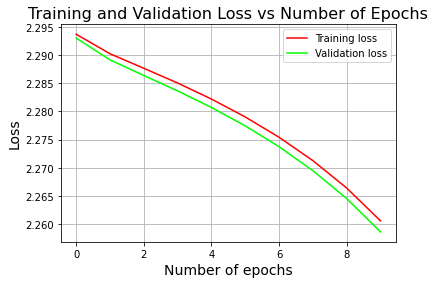

training_acc,0.12276
validation_accuracy,0.133
training_loss,2.26056
validation cost,2.2586
epoch,11
_runtime,118
_timestamp,1615361608
_step,9


training_acc,▁▁▁▁▁▁▂▄▆█
validation_accuracy,▁▁▁▁▁▁▂▄▆█
training_loss,█▇▇▆▆▅▄▃▂▁
validation cost,█▇▇▆▅▅▄▃▂▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: j3egfqtf with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


lr_0.001_ac_sigmoid_in_random_uniform_op_nadam_bs_32_L2_0.0005_ep_5_nn_64_nh_3
Epoch number : 2
Training cost:  1.8130085579986863 	Validation cost: 1.8211449447282761
Epoch number : 4
Training cost:  1.054697330642914 	Validation cost: 1.0665345458563225
Epoch number : 6
Training cost:  0.5623792060036352 	Validation cost: 0.5627116412008369

Final training cost: 0.5623792060036352


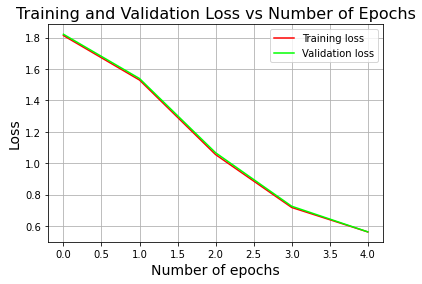

training_acc,0.80298
validation_accuracy,0.7995
training_loss,0.56238
validation cost,0.56271
epoch,6
_runtime,61
_timestamp,1615361678
_step,4


training_acc,▁▃▅▇█
validation_accuracy,▁▃▅▇█
training_loss,█▆▄▂▁
validation cost,█▆▄▂▁
epoch,▁▃▅▆█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 4cj2v0b9 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.001_ac_tanh_in_xavier_op_sgd_bs_16_L2_0.0005_ep_5_nn_128_nh_5
Epoch number : 2
Training cost:  0.726807337343559 	Validation cost: 0.7345397880844541
Epoch number : 4
Training cost:  0.5086481043774659 	Validation cost: 0.5122553322716891
Epoch number : 6
Training cost:  0.4528681753078811 	Validation cost: 0.45727407265154824

Final training cost: 0.4528681753078811


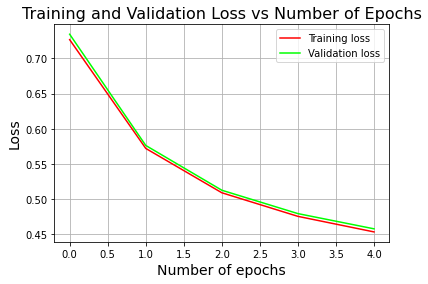

training_acc,0.84074
validation_accuracy,0.8355
training_loss,0.45287
validation cost,0.45727
epoch,6
_runtime,127
_timestamp,1615361814
_step,4


training_acc,▁▅▆▇█
validation_accuracy,▁▅▇▇█
training_loss,█▄▂▂▁
validation cost,█▄▂▂▁
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 9lztifrr with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.0001_ac_tanh_in_xavier_op_RMSprop_bs_64_L2_0.0005_ep_20_nn_32_nh_3
Epoch number : 2
Training cost:  0.7533606103724603 	Validation cost: 0.7641397518749928
Epoch number : 4
Training cost:  0.475774806749655 	Validation cost: 0.4825281262851968
Epoch number : 6
Training cost:  0.4165525571225367 	Validation cost: 0.42458544264042297
Epoch number : 8
Training cost:  0.38729651990177344 	Validation cost: 0.398498713812988
Epoch number : 10
Training cost:  0.3684108546173487 	Validation cost: 0.3832242862160071
Epoch number : 12
Training cost:  0.35475405354019607 	Validation cost: 0.37316675266420385
Epoch number : 14
Training cost:  0.3441260190879369 	Validation cost: 0.36601170964048135
Epoch number : 16
Training cost:  0.33540299800903617 	Validation cost: 0.3606041859800157
Epoch number : 18
Training cost:  0.3279576883312946 	Validation cost: 0.35631286752034597
Epoch number : 20
Training cost:  0.32141707574953826 	Validation cost: 0.35277553284056407

Final training cost: 0.3

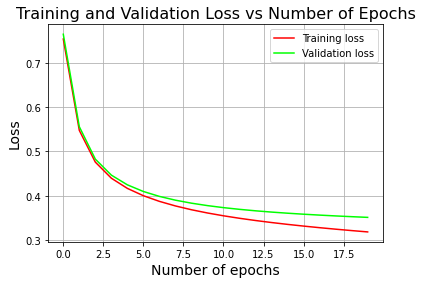

training_acc,0.88652
validation_accuracy,0.87217
training_loss,0.31841
validation cost,0.35122
epoch,21
_runtime,79
_timestamp,1615361902
_step,19


training_acc,▁▄▅▅▆▆▇▇▇▇▇▇▇▇██████
validation_accuracy,▁▄▅▆▆▇▇▇▇▇██████████
training_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
validation cost,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: ju5ymzbn with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.001_ac_tanh_in_xavier_op_sgd_bs_512_L2_0_ep_20_nn_64_nh_3
Epoch number : 2
Training cost:  2.0936092122073644 	Validation cost: 2.0951630684345375
Epoch number : 4
Training cost:  1.7947187557100068 	Validation cost: 1.7996848521523012
Epoch number : 6
Training cost:  1.5959110380278136 	Validation cost: 1.6033200826582124
Epoch number : 8
Training cost:  1.4525812572305772 	Validation cost: 1.4611263698310653
Epoch number : 10
Training cost:  1.3433729435203317 	Validation cost: 1.352472023288948
Epoch number : 12
Training cost:  1.256681199274441 	Validation cost: 1.2660698979597063
Epoch number : 14
Training cost:  1.1857265371537646 	Validation cost: 1.1952718561308815
Epoch number : 16
Training cost:  1.1263005907461203 	Validation cost: 1.1359242185468137
Epoch number : 18
Training cost:  1.075666489956865 	Validation cost: 1.0853158241407668
Epoch number : 20
Training cost:  1.0319568366427176 	Validation cost: 1.0415948111669628

Final training cost: 1.0122654756160652


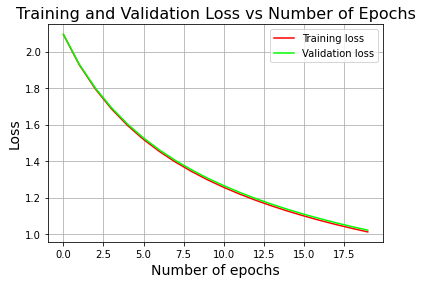

training_acc,0.69828
validation_accuracy,0.69183
training_loss,1.01227
validation cost,1.02189
epoch,21
_runtime,94
_timestamp,1615362005
_step,19


training_acc,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
validation_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
training_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
validation cost,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: ho0fb3ow with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.001_ac_tanh_in_random_uniform_op_momentum_bs_64_L2_0.5_ep_20_nn_128_nh_4
Epoch number : 2
Training cost:  2.2974941233602353 	Validation cost: 2.2972263696220723
Epoch number : 4
Training cost:  2.2918211365209697 	Validation cost: 2.291064164815115
Epoch number : 6
Training cost:  2.28733925009611 	Validation cost: 2.286315745237042
Epoch number : 8
Training cost:  2.282363738840701 	Validation cost: 2.2811556278516005
Epoch number : 10
Training cost:  2.2761621586676686 	Validation cost: 2.274789349104755
Epoch number : 12
Training cost:  2.2678639276152155 	Validation cost: 2.26632460503115
Epoch number : 14
Training cost:  2.2558215074167873 	Validation cost: 2.2541216889730635
Epoch number : 16
Training cost:  2.236177958190839 	Validation cost: 2.234388438761706
Epoch number : 18
Training cost:  2.1974115951115176 	Validation cost: 2.195892243381939
Epoch number : 20
Training cost:  2.094168241582943 	Validation cost: 2.094786422651181

Final training cost: 1.994283805778369

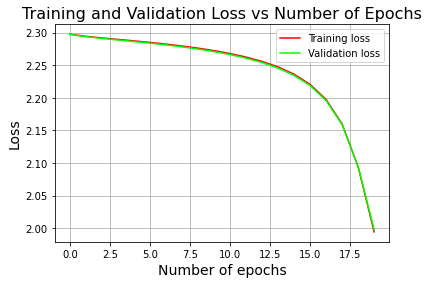

training_acc,0.22574
validation_accuracy,0.22267
training_loss,1.99428
validation cost,1.99783
epoch,21
_runtime,277
_timestamp,1615362292
_step,19


training_acc,▁▁▁▁▁▁▁▁▁▂▂▃▃▃▄▄▅▅▅█
validation_accuracy,▁▁▁▁▁▁▁▂▂▂▃▃▄▄▄▅▅▅▆█
training_loss,█████████▇▇▇▇▇▇▆▆▅▃▁
validation cost,████████▇▇▇▇▇▇▇▆▆▅▃▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: hpl34mu6 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.001_ac_relu_in_random_uniform_op_nestorov_bs_16_L2_0_ep_5_nn_32_nh_4
Epoch number : 2
Training cost:  2.302578602548402 	Validation cost: 2.3025778534026937
Epoch number : 4
Training cost:  2.302578602548402 	Validation cost: 2.3025778534026937
Epoch number : 6
Training cost:  2.302578602548402 	Validation cost: 2.3025778534026937

Final training cost: 2.302578602548402


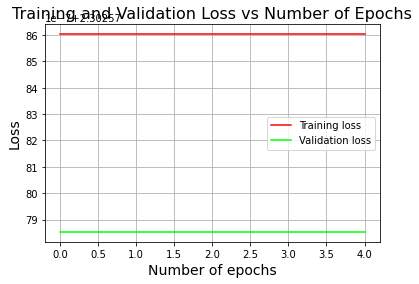

training_acc,0.10019
validation_accuracy,0.09833
training_loss,2.30258
validation cost,2.30258
epoch,6
_runtime,24
_timestamp,1615362326
_step,4


training_acc,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
training_loss,▁▁▁▁▁
validation cost,▁▁▁▁▁
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 0pwxuubd with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 512
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nestorov


lr_0.0001_ac_sigmoid_in_random_uniform_op_nestorov_bs_512_L2_0.5_ep_10_nn_64_nh_3
Epoch number : 2
Training cost:  2.302700073745888 	Validation cost: 2.302868393195447
Epoch number : 4
Training cost:  2.302700073745888 	Validation cost: 2.302868393195447
Epoch number : 6
Training cost:  2.302700073745888 	Validation cost: 2.302868393195447
Epoch number : 8
Training cost:  2.302700073745888 	Validation cost: 2.302868393195447
Epoch number : 10
Training cost:  2.302700073745888 	Validation cost: 2.302868393195447

Final training cost: 2.302700073745888


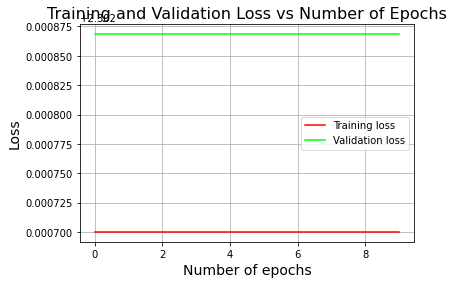

training_acc,0.10093
validation_accuracy,0.09167
training_loss,2.3027
validation cost,2.30287
epoch,11
_runtime,49
_timestamp,1615362384
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ulay0xed with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: adam


lr_0.001_ac_relu_in_random_uniform_op_adam_bs_16_L2_0.5_ep_20_nn_32_nh_5
Epoch number : 2
Training cost:  2.3052728845031973 	Validation cost: 2.306150963469002
Epoch number : 4
Training cost:  2.3101870301087346 	Validation cost: 2.310653252516779
Epoch number : 6
Training cost:  2.310533670185963 	Validation cost: 2.3110046398442496
Epoch number : 8
Training cost:  2.3109782658076496 	Validation cost: 2.3113432967724257
Epoch number : 10
Training cost:  2.3116353948283974 	Validation cost: 2.311916747774005
Epoch number : 12
Training cost:  2.3122533700087633 	Validation cost: 2.3125343315321625
Epoch number : 14
Training cost:  2.3126462817349247 	Validation cost: 2.312975981643069
Epoch number : 16
Training cost:  2.312703975426497 	Validation cost: 2.3130730580273475
Epoch number : 18
Training cost:  2.312939602083382 	Validation cost: 2.3134086720988667
Epoch number : 20
Training cost:  2.3131635583602255 	Validation cost: 2.313815090977876

Final training cost: 2.313218804489383

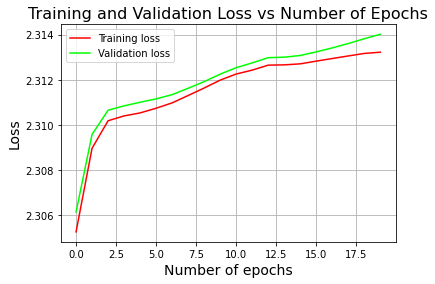

training_acc,0.09985
validation_accuracy,0.10133
training_loss,2.31322
validation cost,2.31401
epoch,21
_runtime,801
_timestamp,1615363204
_step,19


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▄▅▆▆▆▆▆▇▇▇▇▇███████
validation cost,▁▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▁▁▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▁▁▁▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: sl2isf1y with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.001_ac_tanh_in_xavier_op_nadam_bs_512_L2_0.5_ep_5_nn_128_nh_4
Epoch number : 2
Training cost:  0.6002814521216654 	Validation cost: 0.6264528116660081
Epoch number : 4
Training cost:  0.5317470284496164 	Validation cost: 0.5639103619237773
Epoch number : 6
Training cost:  0.4727284552975005 	Validation cost: 0.5017863693831561

Final training cost: 0.4727284552975005


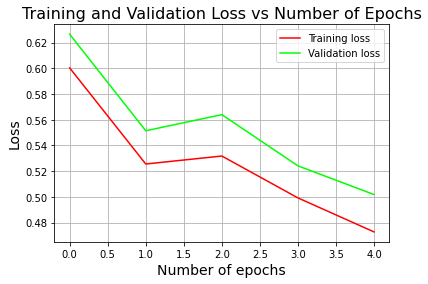

training_acc,0.82694
validation_accuracy,0.82483
training_loss,0.47273
validation cost,0.50179
epoch,6
_runtime,60
_timestamp,1615363276
_step,4


training_acc,▁▄▂▆█
validation_accuracy,▁▃▂▆█
training_loss,█▄▄▂▁
validation cost,█▄▄▂▁
epoch,▁▃▅▆█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 1otoevzp with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.0001_ac_tanh_in_random_uniform_op_adam_bs_16_L2_0_ep_5_nn_128_nh_5
Epoch number : 2
Training cost:  1.6863194847073024 	Validation cost: 1.693252022405882
Epoch number : 4
Training cost:  0.8857001308881526 	Validation cost: 0.8836734655564377
Epoch number : 6
Training cost:  0.5596683627219918 	Validation cost: 0.5711253778115515

Final training cost: 0.5596683627219918


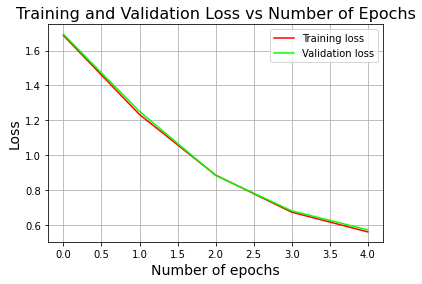

training_acc,0.81241
validation_accuracy,0.80167
training_loss,0.55967
validation cost,0.57113
epoch,6
_runtime,211
_timestamp,1615363496
_step,4


training_acc,▁▄▆██
validation_accuracy,▁▄▆██
training_loss,█▅▃▂▁
validation cost,█▅▃▂▁
epoch,▁▃▅▆█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: elwpiedt with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.001_ac_sigmoid_in_xavier_op_nadam_bs_64_L2_0.5_ep_5_nn_32_nh_3
Epoch number : 2
Training cost:  1.5913119509318518 	Validation cost: 1.5978445545995832
Epoch number : 4
Training cost:  1.184172422848463 	Validation cost: 1.1896765998161474
Epoch number : 6
Training cost:  1.1134047631170536 	Validation cost: 1.1207232129279308

Final training cost: 1.1134047631170536


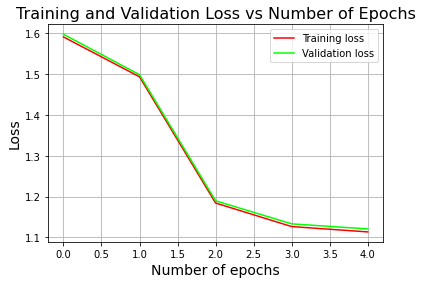

training_acc,0.60506
validation_accuracy,0.6055
training_loss,1.1134
validation cost,1.12072
epoch,6
_runtime,25
_timestamp,1615363530
_step,4


training_acc,▁▁▇██
validation_accuracy,▁▁███
training_loss,█▇▂▁▁
validation cost,█▇▂▁▁
epoch,▁▃▅▆█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: rkfh7u3o with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd


lr_0.0001_ac_relu_in_xavier_op_sgd_bs_64_L2_0_ep_20_nn_32_nh_3
Epoch number : 2
Training cost:  2.281081393343111 	Validation cost: 2.283548798082168
Epoch number : 4
Training cost:  2.215368906612422 	Validation cost: 2.2190303814270926
Epoch number : 6
Training cost:  2.160953951886077 	Validation cost: 2.1658358966487947
Epoch number : 8
Training cost:  2.1040452838867614 	Validation cost: 2.1101289420425284
Epoch number : 10
Training cost:  2.0405307362106613 	Validation cost: 2.047988268138082
Epoch number : 12
Training cost:  1.9683103334717218 	Validation cost: 1.977033350412799
Epoch number : 14
Training cost:  1.8879047796845598 	Validation cost: 1.897758986681562
Epoch number : 16
Training cost:  1.8011415807684772 	Validation cost: 1.8119352526152266
Epoch number : 18
Training cost:  1.711361079352744 	Validation cost: 1.7228167715918838
Epoch number : 20
Training cost:  1.6195213770072685 	Validation cost: 1.6311715994108558

Final training cost: 1.5740988295761698


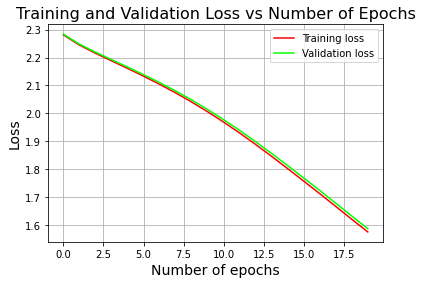

training_acc,0.4538
validation_accuracy,0.44417
training_loss,1.5741
validation cost,1.58585
epoch,21
_runtime,45
_timestamp,1615363585
_step,19


training_acc,▁▂▂▂▂▃▃▃▄▅▅▆▆▆▇▇▇▇▇█
validation_accuracy,▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇▇▇█
training_loss,██▇▇▇▇▆▆▆▅▅▅▄▄▃▃▂▂▁▁
validation cost,██▇▇▇▇▆▆▆▅▅▅▄▄▃▃▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 3k47gax5 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.0001_ac_sigmoid_in_random_uniform_op_nestorov_bs_64_L2_0.5_ep_10_nn_32_nh_5
Epoch number : 2
Training cost:  2.3026094191161226 	Validation cost: 2.302593960793497
Epoch number : 4
Training cost:  2.3026094191161226 	Validation cost: 2.302593960793497
Epoch number : 6
Training cost:  2.3026094191161226 	Validation cost: 2.302593960793497
Epoch number : 8
Training cost:  2.3026094191161226 	Validation cost: 2.302593960793497
Epoch number : 10
Training cost:  2.3026094191161226 	Validation cost: 2.302593960793497

Final training cost: 2.3026094191161226


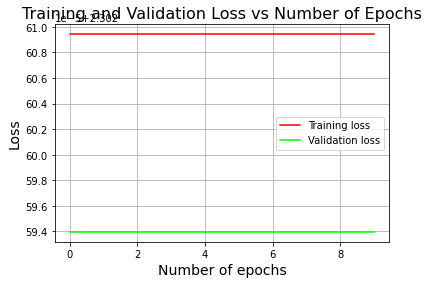

training_acc,0.09965
validation_accuracy,0.10317
training_loss,2.30261
validation cost,2.30259
epoch,11
_runtime,48
_timestamp,1615363642
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: u2t2cdkk with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd


lr_0.001_ac_tanh_in_random_uniform_op_sgd_bs_512_L2_0.5_ep_5_nn_32_nh_5
Epoch number : 2
Training cost:  2.302589148838737 	Validation cost: 2.3026270845540884
Epoch number : 4
Training cost:  2.3025888252626325 	Validation cost: 2.302629993384612
Epoch number : 6
Training cost:  2.3025885150481322 	Validation cost: 2.3026328474363518

Final training cost: 2.3025885150481322


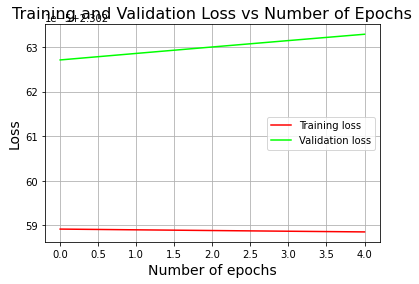

training_acc,0.10093
validation_accuracy,0.09167
training_loss,2.30259
validation cost,2.30263
epoch,6
_runtime,18
_timestamp,1615363670
_step,4


training_acc,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
training_loss,█▆▆▃▁
validation cost,▁▃▅▆█
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


In [68]:
sweep_config = {
  "name": "Assignment 1 - Cross Entropy Loss",
  "metric": {
      "name":"validation_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "learning_rate": {
            "values": [0.001, 0.0001]
        },
        "activation_f": {
            "values": ["sigmoid", "relu", "tanh"]
        },
        "init_mode": {
            "values": ["xavier", "random_uniform", "random_normal"]
        },
        "optimizer": {
            "values": ["sgd", "momentum", "nestorov", "adam", "nadam", "RMSprop"]
        },
        "batch_size": {
            "values": [16,32,64,128,256,512]
        },
        "epochs": {
            "values": [5, 10, 20, 40]
        },
        "L2_lamb": {
            "values": [0, 0.0005, 0.5]
        },
        "num_neurons": {
            "values": [32, 64, 128]
        },
        "num_hidden": {
            "values": [3, 4, 5]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="ee17b154tony", project="dl_assignment1")
wandb.agent(sweep_id, NN_fit, count=100)

#### Training the model

Epoch number : 2
Training cost:  0.5230674480428092 	Validation cost: 0.5300457097083761
Epoch number : 4
Training cost:  0.4221027675900801 	Validation cost: 0.450332581865339
Epoch number : 6
Training cost:  0.39440145186885484 	Validation cost: 0.4254284332467785
Epoch number : 8
Training cost:  0.4152649870999991 	Validation cost: 0.4427350218496815
Epoch number : 10
Training cost:  0.3662020848616784 	Validation cost: 0.40659684404560564
Epoch number : 12
Training cost:  0.3639959872041472 	Validation cost: 0.4002676753988165
Epoch number : 14
Training cost:  0.36824396209407434 	Validation cost: 0.41260595268460776
Epoch number : 16
Training cost:  0.3889437689122067 	Validation cost: 0.4366396891965923
Epoch number : 18
Training cost:  0.37836495951230603 	Validation cost: 0.42479722138871134
Epoch number : 20
Training cost:  0.34727014024794434 	Validation cost: 0.38796481115132
Epoch number : 22
Training cost:  0.3618487209695926 	Validation cost: 0.41294174363124586
Epoch num

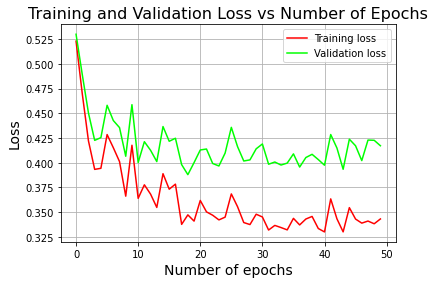

In [ ]:
learned_parameters, epoch_cost = NN_fit(X_train, y_train_one_hot, X_val, y_val_one_hot,
                            learning_rate=LEARNING_RATE,
                            activation_f = ACTIVATION,
                            init_mode = INITIALIZER,
                            optimizer = OPTIMIZER,
                            batch_size = BATCH_SIZE,
                            loss = LOSS,
                            epochs = EPOCHS,
                            L2_lamb = L2_lambda)

#### Model Evaluation

In [ ]:
NN_evaluate(X_train, y_train, X_test, y_test, learned_parameters, ACTIVATION)

Training accuracy = 88 %
Test accuracy = 84 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.85      0.70      0.77      1000
           1       0.99      0.95      0.97      1000
           2       0.77      0.71      0.74      1000
           3       0.85      0.87      0.86      1000
           4       0.69      0.79      0.74      1000
           5       0.97      0.93      0.95      1000
           6       0.60      0.65      0.62      1000
           7       0.88      0.96      0.92      1000
           8       0.93      0.96      0.95      1000
           9       0.96      0.91      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000

